In [1]:
# LOAD LIBRARIES
from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table, join
import agama
import skfda
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.representation.basis import (BSpline,Fourier,Monomial)
from skfda.exploratory.visualization import FPCAPlot
import emd

plt.rcParams['font.size'] = 12

# DATA LOADER
class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    oo_age = None
    oo_orbit = None
    oo_actions = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)
            z=None
            VZ=None

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        indphi&=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,z,VR,Vphi,VZ,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=True, source_id=False):
        if self.oo == None or self.new != new:
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo
        print(oo.keys())
        
        VR,Vphi,VZ,x,y,z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        sid = np.array(oo['source_id'], dtype=np.int64)
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,z,VR,Vphi,VZ,R,Lz,phi,sid=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],sid[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,sid=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],sid[indphi]
        
        DATA = True
        if source_id:
            return x,y,z,VR,Vphi,VZ,R,Lz,phi,sid
        return x,y,z,VR,Vphi,VZ,R,Lz,phi
    
    def load_data_ages(self, xmin=1500, xmax=3500, phi_range=0.4):
        #path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
        #oo = Table.read(path, format='fits')
        #ages = Table.read('o_galpy/agesGDR3RVS_reduced.fits')
        #joined = join(oo,ages,keys='source_id')
        #print(joined.colnames)
        #print(joined)
        #joined.write('o_galpy/agesGDR3RVS_joined.fits', format='fits')
        #return
        #path = 'o_galpy/agesGDR3RVS_joined.fits'
        #oo = Table.read(path, format='fits')
        #indphi = ~np.isnan(np.array(oo['age']))
        #clean = oo[indphi]
        #clean.write('o_galpy/agesGDR3RVS_clean.fits', format='fits')
        #return
        
        if self.oo_age is None:
            path = 'o_galpy/agesGDR3RVS_clean.fits'
            self.oo_age = Table.read(path, format='fits')
        oo = self.oo_age

        VR,Vphi,VZ,x,y,z,R,phi,age,age_error=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi'],oo['age'],oo['age_error']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,age,age_error=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],age[indphi],age_error[indphi]
        
        DATA = True
        return x,y,z,VR,Vphi,VZ,R,Lz,phi,age,age_error
    
    def load_data_orbits(self, xmin=1500, xmax=3500, phi_range=0.4):
        if self.oo_orbit is None:
            path = 'o_galpy/orbitsGDR3RVS_joined.fits'
            self.oo_orbit = Table.read(path, format='fits')
        oo = self.oo_orbit

        VR,Vphi,VZ,x,y,z,R,phi,Zmax,Jz,Jr=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi'],oo['Zmax_med_dgeo'],oo['Jz_med_dgeo'],oo['Jr_med_dgeo']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,Zmax,Jz,Jr=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],Zmax[indphi],Jz[indphi],Jr[indphi]
        
        DATA = True
        return x,y,z,VR,Vphi,VZ,R,Lz,phi,Zmax,Jz,Jr
    
    def load_data_actions(self, xmin, xmax, phi_range):
        if self.oo_actions is None:
            self.oo_actions = Table.read('actions_joined.fits', format='fits')
        tj = self.oo_actions
        
        lst = ('source_id','X','Y','Z','VR','Vphi','VZ','R','phi', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi')
        source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (tj[i] for i in lst)
        Lz = -R * Vphi
        phi = -phi
        Vphi = -Vphi
        
        indphi = ~np.isnan(Jr)
        indphi &= abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = (i[indphi] for i in (source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz))
        
        return source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz
    
l = Loader()

# AUXILIARY_FUNCTIONS

def smooth_bins(x, y, xmin, xmax, binsize, calc_error=False,median=False):
    binsLZ=np.arange(xmin,xmax,binsize)
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    error = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            if len(means) == 0:
                means.append(0)
                error.append(0)
            else:
                means.append(means[-1])
                error.append(error[-1])
        else:
            if median:
                if np.isnan(np.ma.median(rel)):
                    print(rel)
                means.append(np.ma.median(rel))
            else:
                means.append(np.mean(rel))
            err = np.std(rel)/np.sqrt(len(rel))
            error.append(err)
    ypol = np.array(means)
    error = np.array(error)
    if calc_error:
        return xpol, ypol, error
    return xpol, ypol

# Get an equispaced curve from a number of points
def curve_from_bins(nx, ny, N):
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    return xpol, ypol

# Perform Fourier transform on a curve
def fourier_from_curve(xpol, ypol):
    N = len(xpol)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((xpol[-1]-xpol[0]) / abs(xf * N))
    return xfr, yf

def do_emd(xpol, ypol):
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    sample_rate=1
    imf = emd.sift.sift(ypol)
    IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
    freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
    #freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
    hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='density')
    return hht_f, spec

0 2.5 8406828 3655832
2.5 5 8406828 1563854
5 10 8406828 1498790
10 20 8406828 1033076
20 inf 8406828 655276
0 5 8406828 1419877
5 10 8406828 1162610
10 20 8406828 1682371
20 60 8406828 2801146
60 inf 8406828 1340824


(-20.0, 30.0)

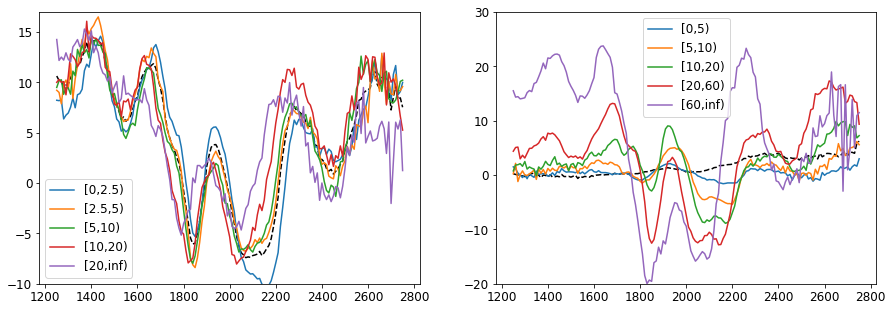

In [2]:
# Lz-VR curves for different actions

XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')
nx, ny = smooth_bins(Lz, VZ, XMIN, XMAX, 10)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,2.5,5,10,20,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jz) & (Jz < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
lims = [0,5,10,20,60,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jr) & (Jr < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-10,17)
ax[1].set_ylim(-20,30)

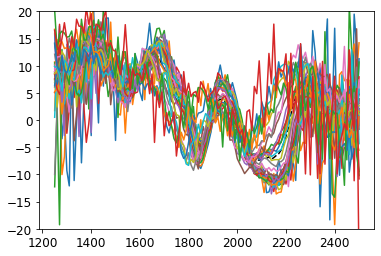

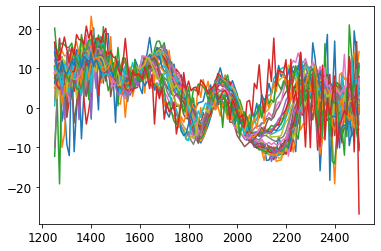

In [14]:
# Same as before (for Jz), but with smaller subdivisions and putting them into a skfda data grid

XMIN = 1250
XMAX = 2500
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
plt.plot(nx,ny,c='k',ls='--')

#lims = [0,1,2,5,10,float('inf')]
#lims = [0,0.5,1,1.5,2,3,4,5,7.5,10,15,20,float('inf')]
lims = 10**np.arange(-1.5,2,0.1)
curves = []
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jz) & (Jz < high)
    # print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    curves.append(ny)
    plt.plot(nx,ny,label=f'[{low},{high})')
#plt.legend()
plt.ylim(-20,20)

fd = skfda.FDataGrid(
    data_matrix=curves,
    grid_points=nx,
)

fd.plot();

[0.49756484 0.11944595 0.08412205]
[[-0.71856334  0.30264746  1.        ]
 [-0.66528103  0.41046956 -0.20753834]
 [-0.61047861  0.23482247 -0.60812756]
 [-0.59660768  0.29533751 -0.1066114 ]
 [-0.61320606  0.25522715 -0.04981566]
 [-0.58824028  0.23429642  0.07723802]
 [-0.51749446 -0.05325318 -0.03005848]
 [-0.50453753  0.11850548  0.0543274 ]
 [-0.47241342  0.11484138 -0.08612699]
 [-0.49878715  0.02627269  0.02785494]
 [-0.43054568 -0.07344665 -0.08106638]
 [-0.43758444  0.02402875 -0.0122986 ]
 [-0.41601445 -0.05418405  0.03781934]
 [-0.33363949 -0.11975475 -0.06707483]
 [-0.30317231 -0.16839583 -0.035174  ]
 [-0.2584837  -0.16459192  0.00311333]
 [-0.19729025 -0.22217883  0.00394968]
 [-0.11775943 -0.22213717 -0.01689889]
 [-0.0259     -0.28450814  0.01150506]
 [ 0.08401487 -0.30175499 -0.04148857]
 [ 0.15692535 -0.28414776 -0.05216292]
 [ 0.17941236 -0.23567761 -0.02363035]
 [ 0.21057938 -0.19299605 -0.01355548]
 [ 0.2411992  -0.22559493  0.06140173]
 [ 0.3425009  -0.35883567  0.

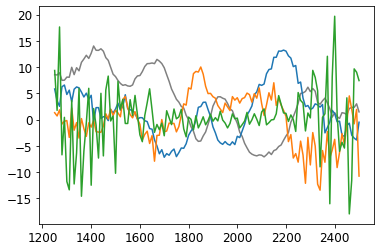

In [75]:
# Perform functional PCA and plot the components (and the mean, which is substracted before performing FPCA, in grey)

fpca = FPCA(n_components=3, components_basis=BSpline(n_basis=50))
weights = fpca.fit_transform(fd)
comps = fpca.components_.data_matrix[:,:,0]
print(fpca.explained_variance_ratio_)

rescal = np.max(np.abs(weights), axis=0)
comps = comps*rescal[:,np.newaxis]
weights = weights/rescal

plt.plot(nx, fd.data_matrix.mean(axis=0), c='gray')
for c in comps:
    plt.plot(nx,c)
print(weights)

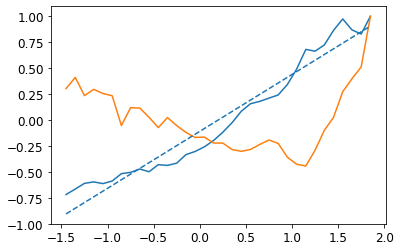

In [76]:
# Plot log(Jz) vs coefficient of each component

logjz = (np.log10(lims[:-1]) + np.log10(lims[1:]))/2
cw = weights[:,0]
plt.plot(logjz, cw)
plt.plot(logjz, weights[:,1])
fm, fn = np.polyfit(logjz, cw, 1)
plt.plot(logjz, fm*logjz+fn, c='C0', ls='--')

[-0.7185633369657498]


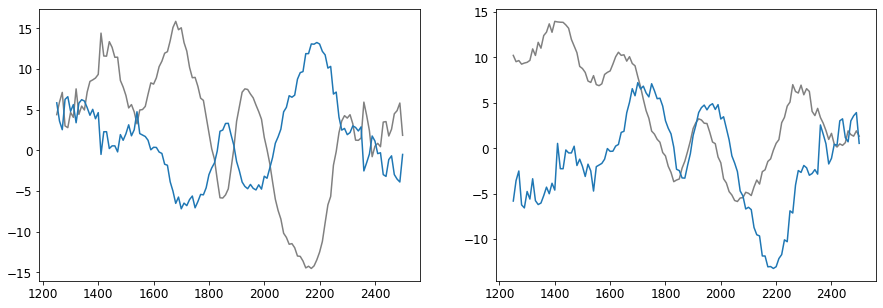

In [99]:
# Fix the coefficient of the first component at Jz=0 to 0.
# Grey is the curve at Jz=0 and blue is the component that is added
# Therefore the curve at Jz=k is grey + blue * f(Jz)
# The other plot is the same but fixing it at Jz=max

fig, ax = plt.subplots(1,2,figsize=(15,5))

mean = fd.mean(axis=0)
remean = mean.copy().data_matrix[:,:,0]
reweights = weights.copy()
ccomps = [comps[0]]
corr = []
for i in range(len(ccomps)):
    corr.append(np.min(weights[:,i]))
    remean += corr[-1] * ccomps[i]
    reweights[:,i] = weights[:,i] - corr[-1]
remean = remean[0]

#plt.plot(nx, bfd_mean)
ax[0].plot(nx, remean, c='grey')
ax[0].plot(nx, comps[0])

ax[1].plot(nx, remean+np.max(weights[:,0])*comps[i], c='grey')
ax[1].plot(nx, -comps[0])


(-15.0, 20.0)

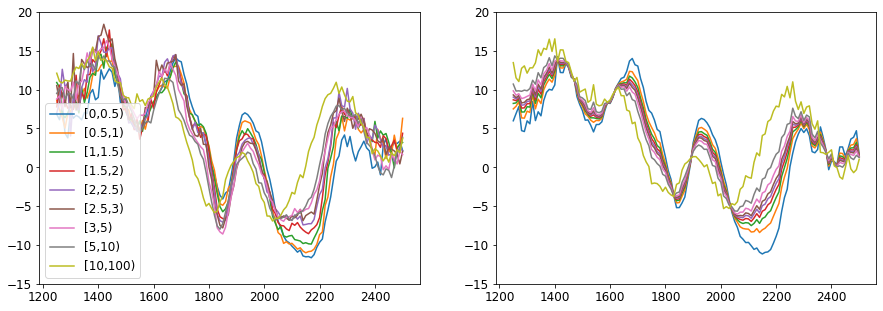

In [102]:
# Reconstruct the curves with the mean and the first component (accuracy check).
# First plot: original curves. Second plot: reconstructed curves.

fig, ax = plt.subplots(1,2,figsize=(15,5))

#tjz = 15
nlims = [0,0.5,1,1.5,2,2.5,3,5,10,100]

i = 0
for low, high in zip(nlims[:-1],nlims[1:]):
    ind = (low <= Jz) & (Jz < high)
    #print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
    
    tjz = fm*np.log10((low+high)/2) + fn - corr
    rec = remean + tjz*comps[0]
    ax[1].plot(nx, rec)
    i += 1

ax[0].legend()
ax[0].set_ylim(-15,20)
ax[1].set_ylim(-15,20)

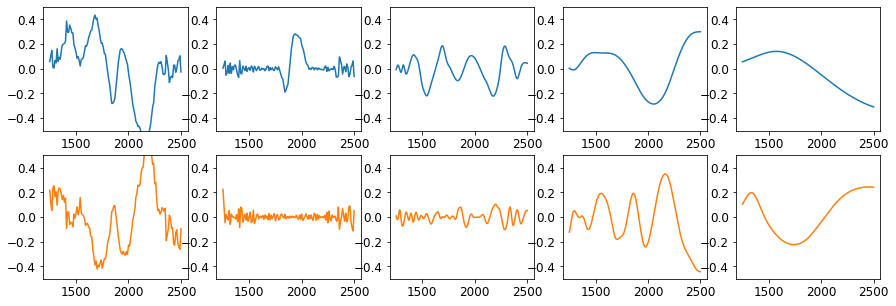

In [105]:
# Empirical mode decomposition on the mean and the first component

YLIM = 0.5
N = 1000
fig, ax = plt.subplots(2,5,figsize=(15,5))
xpol, ypol = curve_from_bins(nx, remean, N)
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
ax[0][0].plot(xpol, ypol, c=f'C0')
ax[0][0].set_ylim(-YLIM,YLIM)
imf = emd.sift.sift(ypol)
for i in range(imf.shape[1]):
    ax[0][i+1].plot(xpol, imf[:,i], c=f'C0')
    ax[0][i+1].set_ylim(-YLIM,YLIM)
    
xpol, ypol = curve_from_bins(nx, comps[0], N)
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
ax[1][0].plot(xpol, ypol, c=f'C1')
ax[1][0].set_ylim(-YLIM,YLIM)
imf = emd.sift.sift(ypol)
for i in range(imf.shape[1]):
    ax[1][i+1].plot(xpol, imf[:,i], c=f'C1')
    ax[1][i+1].set_ylim(-YLIM,YLIM)

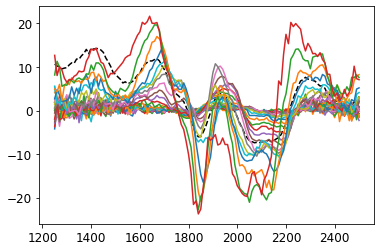

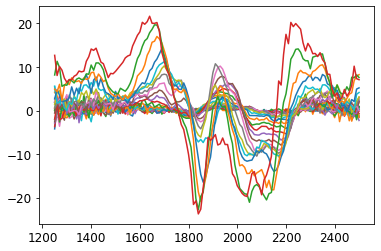

In [9]:
# The next cells reproduce the procedure but for Jr

XMIN = 1250
XMAX = 2500
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
plt.plot(nx,ny,c='k',ls='--')

#lims = [0,1,2,5,10,float('inf')]
#lims = [0,0.5,1,1.5,2,3,4,5,7.5,10,15,20,float('inf')]
lims = 10**np.arange(-0.5,2,0.1)
#lims = np.arange(0,100,2.5)
curves = []
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jr) & (Jr < high)
    #print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    curves.append(ny)
    plt.plot(nx,ny,label=f'[{low},{high})')
#plt.legend()

fd = skfda.FDataGrid(
    data_matrix=curves,
    grid_points=nx,
)

fd.plot();

[0.78826386 0.13668453 0.03066089]
[[-0.24923034  0.24297146  0.26990497]
 [-0.25221636  0.2580156   0.2388946 ]
 [-0.24634105  0.26325587  0.2467605 ]
 [-0.25159395  0.24752192  0.18969916]
 [-0.25310716  0.23058369  0.18305779]
 [-0.24323139  0.22155044  0.15996325]
 [-0.24719325  0.2113869   0.11925504]
 [-0.24341099  0.1939727   0.09085133]
 [-0.23384654  0.16966271  0.05304773]
 [-0.22527658  0.14279756 -0.017072  ]
 [-0.22175825  0.10598149 -0.11747928]
 [-0.20520529  0.0425238  -0.18934271]
 [-0.17853292 -0.02041048 -0.30031499]
 [-0.1624119  -0.11999552 -0.34592979]
 [-0.11973963 -0.23896796 -0.43052655]
 [-0.07036593 -0.38406426 -0.48561596]
 [-0.00747067 -0.5455173  -0.50945275]
 [ 0.0721501  -0.56109192 -0.44448618]
 [ 0.16314633 -0.44833981 -0.08858746]
 [ 0.25054432 -0.32529971  0.6553743 ]
 [ 0.40740568 -0.4135188   1.        ]
 [ 0.64215177 -0.37851306  0.49313666]
 [ 0.87553401  0.1054947  -0.37425509]
 [ 1.          1.         -0.39688257]]


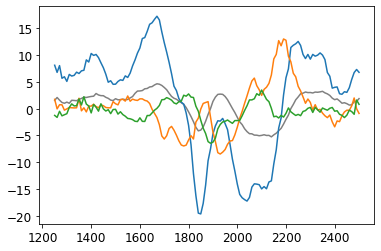

In [10]:
# Perform functional PCA and plot the components (and the mean, which is substracted before performing FPCA, in grey)

fpca = FPCA(n_components=3, components_basis=BSpline(n_basis=50))
weights = fpca.fit_transform(fd)
comps = fpca.components_.data_matrix[:,:,0]
print(fpca.explained_variance_ratio_)

rescal = np.max(np.abs(weights), axis=0)
comps = comps*rescal[:,np.newaxis]
weights = weights/rescal

plt.plot(nx, fd.data_matrix.mean(axis=0), c='gray')
for c in comps:
    plt.plot(nx,c)
print(weights)

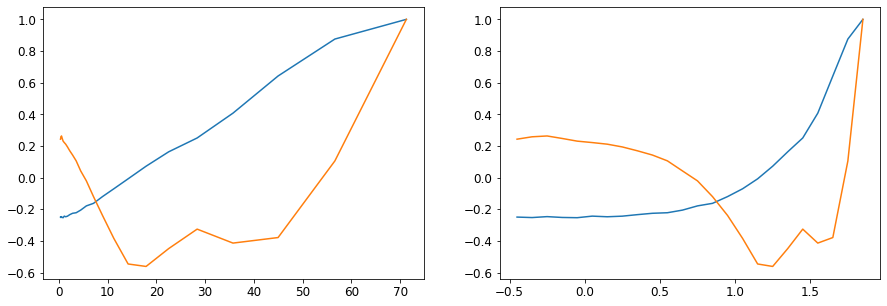

In [11]:
# Plot Jr, log(Jr) vs coefficient of each component

fig, ax = plt.subplots(1,2,figsize=(15,5))
jza = (lims[:-1] + lims[1:])/2
logjz = (np.log10(lims[:-1]) + np.log10(lims[1:]))/2
cw = weights[:,0]
ax[0].plot(jza, cw)
ax[0].plot(jza, weights[:,1])
ax[1].plot(logjz, cw)
ax[1].plot(logjz, weights[:,1])

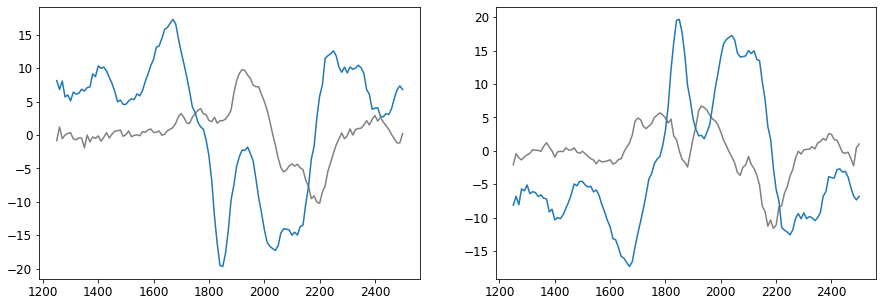

In [13]:
# Fix the coefficient of the first component at Jr=0 to 0.
# Grey is the curve at Jr=0 and blue is the component that is added
# Therefore the curve at Jr=k is grey + blue * f(Jr)
# The other plot is the same but fixing it at Jr=max

fig, ax = plt.subplots(1,2,figsize=(15,5))

basis = BSpline(n_basis=50)
basis_fd = fd.to_basis(basis)
bfd_grid = basis_fd.to_grid(nx).data_matrix[:,:,0]
bfd_mean = bfd_grid.mean(axis=0)
remean = bfd_mean.copy()
reweights = weights.copy()
for i in range(len(comps)):
    remean += np.min(weights[:,i]) * comps[i]
    reweights[:,i] = weights[:,i] - np.min(weights[:,i])

#plt.plot(nx, bfd_mean)
ax[0].plot(nx, remean, c='grey')
ax[0].plot(nx, comps[0])

ax[1].plot(nx, remean+np.max(weights[:,0])*comps[i], c='grey')
ax[1].plot(nx, -comps[0])